# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import when
from pyspark.sql import Window
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler,MinMaxScaler
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

import seaborn as sns

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC , GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.linalg import SparseVector, DenseVector

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify-capstone") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'a92bb77aa5ce'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '44885'),
 ('spark.app.id', 'local-1619122479243'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'sparkify-capstone'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`.
In the following section I load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

### Drop Rows with Missing Values

In [5]:
#drop null values annd duplicates as well as the empty string userId
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.select("userId").dropDuplicates().sort("userId")
df = df.filter(df["userId"] != "")

### Remove Columns That Won't Be Used

In [6]:
df=df.drop('firstName','lastName').filter(df.auth.isin(['Guest', 'Logged Out']) == False)

In [7]:
df.groupby('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



# Exploratory Data Analysis
In thee following section I perform EDA and doing basic manipulations within Spark.To get to know the data a bit better and check for possibilities for future feature eengineering part

In [8]:
#show the most popular artist
popular_artist = df.groupby('artist').count().sort(desc("count")).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



In [9]:
#show the number number of event count per activity(page) 
df.groupby('page').count().sort(desc("count")).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



### Define Churn

Define churn by using the `Cancellation Confirmation` events , which happen for both paid and free users.

In [10]:
#define churn, as also shown in the lecture
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
dfc = df.withColumn("Churned", flag_churn_event("page"))
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
dfc = dfc.withColumn("phase", Fsum("Churned").over(windowval))
dfc.filter(dfc.Churned == 0).show(2)

+----------+---------+------+-------------+---------+-----+--------------------+------+--------+-------------+---------+----+------+-------------+--------------------+------+-------+-----+
|    artist|     auth|gender|itemInSession|   length|level|            location|method|    page| registration|sessionId|song|status|           ts|           userAgent|userId|Churned|phase|
+----------+---------+------+-------------+---------+-----+--------------------+------+--------+-------------+---------+----+------+-------------+--------------------+------+-------+-----+
|      null|Logged In|     F|           34|     null| free|Bridgeport-Stamfo...|   PUT|  Logout|1538016340000|      187|null|   307|1542823952000|"Mozilla/5.0 (iPh...|100010|      0|    0|
|Lily Allen|Logged In|     F|           33|185.25995| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|      187|  22|   200|1542823951000|"Mozilla/5.0 (iPh...|100010|      0|    0|
+----------+---------+------+-------------+---------+--

In [11]:
print((dfc.count(), len(dfc.columns)))

(278154, 18)


### Explore Data
Perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
dfc.filter(dfc.Churned == 1).select('gender') \
    .groupBy('gender') \
    .agg({'gender':'count'}) \
    .withColumnRenamed('count(gender)', 'Gendercount') \
    .sort(desc('Gendercount')) \
    .show()

+------+-----------+
|gender|Gendercount|
+------+-----------+
|     M|         32|
|     F|         20|
+------+-----------+



Text(0.5,0,'Churn Status')

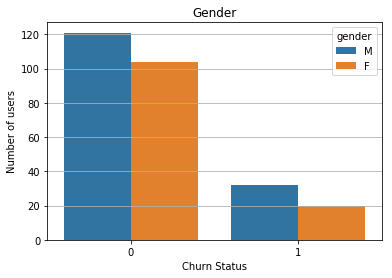

In [13]:
# Bar plot for the gender distribution of churned users compared to users who stayed active
plt.grid(True)
dfc_pd = dfc.drop_duplicates(['userId', 'gender','Churned']).groupby(['Churned', 'gender']).count().sort("Churned").toPandas()
sns.barplot(x = 'Churned', y = 'count', data = dfc_pd, hue = 'gender')
plt.title("Gender")
plt.ylabel('Number of users')
plt.xlabel('Churn Status')

In [14]:
dfc.filter(dfc.Churned == 1) \
    .select('level') \
    .groupBy('level') \
    .agg({'level':'count'}) \
    .withColumnRenamed('count(level)', 'Levelcount') \
    .sort(desc('Levelcount')) \
    .show()

+-----+----------+
|level|Levelcount|
+-----+----------+
| paid|        31|
| free|        21|
+-----+----------+



Text(0.5,0,'Churn Status')

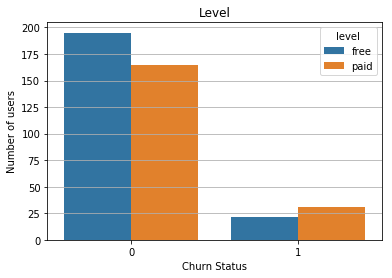

In [15]:
# Bar plot for the level distribution of churned users compared to users who stayed active
plt.grid(True)
dfc_pd = dfc.drop_duplicates(['userId', 'level','Churned']).groupby(['Churned', 'level']).count().sort("Churned").toPandas()
sns.barplot(x = 'Churned', y = 'count', data = dfc_pd, hue = 'level')
plt.title("Level")
plt.ylabel('Number of users')
plt.xlabel('Churn Status')

# Feature Engineering

#### Unique User ID-Churn Status Combination

In [16]:
#get distinct user_id/churn status
df_distinct=dfc.select('userId', col('Churned')).dropDuplicates()

#### User Age Feature

In [17]:
#calculating how long the user has been registered and creating a user_age column on it
dfc=dfc.withColumn('user_age',(df.ts - df.registration)/3600000)

#creating a window function to get the max age value as user age - per user
w = Window().partitionBy("userId").orderBy(col("user_age").desc())

#creating a new dataframe per distinct user_age-userId combination
user_age=dfc.withColumn("rn", row_number().over(w)).where(col("rn") == 1).select("userId", "user_age").dropDuplicates()

#### User Gender and Level Features

In [18]:
#changing the gender column to binary
dfc=dfc.withColumn('Is_Female', when(col('gender') == 'F', 1).otherwise(0)).dropDuplicates()

#getting unique gender-userId combination
user_gender=dfc.select('userId', col('Is_Female')).dropDuplicates()

#changing the level column to binary
dfc=dfc.withColumn('Is_Paid', when(col('level') == 'paid', 1).otherwise(0))              

#creating a window function to get the max age value as user age - per user
w = Window().partitionBy("userId").orderBy(col("user_age").desc())

#creating a new dataframe with latest level info-userId combination
user_level=dfc.withColumn("rn", row_number().over(w)).where(col("rn") == 1).select("userId", "is_Paid").dropDuplicates()

#### Features Based on User Events

In [19]:
#number of the songs that a user listened
songlistened = dfc.groupBy(['userId']).agg(Fsum(when(col('page') == 'Add Friend', 1)).alias('NrFriends'))
#number of friends that a user added
nr_friends = dfc.groupBy(['userId']).agg(Fsum(when(col('page') == 'NextSong', 1)).alias('NrSongListened'))
#number of songs that a user downvoted
voted_down = dfc.groupBy(['userId']).agg(Fsum(when(col('page') == 'Thumbs Down', 1)).alias('NrThumbsDown'))
#number of songs that a user upvoted
voted_up = dfc.groupBy(['userId']).agg(Fsum(when(col('page') == 'Thumbs Up', 1)).alias('NrThumbsUp'))

#### Joining all created features into a final df

In [20]:
#joining the newly created features to main dataframe on UserId
df_f=df_distinct.join(user_age,'userId', "left")\
    .join(user_level,'userId', "left")\
    .join(user_gender,'userId', "left")\
    .join(songlistened,'userId', "left")\
    .join(nr_friends,'userId', "left")\
    .join(voted_down,'userId', "left")\
    .join(voted_up,'userId', "left")

In [21]:
df_f=df_f.fillna(0)

#### Select Feature Columns and Finalise Table Before Modeling

In [22]:
# Select Final Columns and Dataframe
feature_columns = ['userId', 'Churned',\
                  'user_age','Is_Female'\
                   ,'Is_Paid','NrSongListened','NrFriends'\
                   ,'NrThumbsDown', 'NrThumbsUp']
df_final = df_f.select(feature_columns).withColumnRenamed('Churned', 'label').withColumnRenamed('Is_Female', 'gender_binary')\
            .withColumnRenamed('Is_Paid', 'level_binary')
df_final.show(2)

+------+-----+------------------+-------------+------------+--------------+---------+------------+----------+
|userId|label|          user_age|gender_binary|level_binary|NrSongListened|NrFriends|NrThumbsDown|NrThumbsUp|
+------+-----+------------------+-------------+------------+--------------+---------+------------+----------+
|100010|    0|1335.4477777777777|            1|           0|           275|        4|           5|        17|
|200002|    0|1681.7911111111111|            0|           1|           387|        4|           6|        21|
+------+-----+------------------+-------------+------------+--------------+---------+------------+----------+
only showing top 2 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Logistic Regression

In [27]:
#split the data to train and test
train, test = df_final.randomSplit([0.7, 0.3], seed=18)

In [28]:
print((train.count(), len(train.columns)))
print((test.count(), len(test.columns)))

(186, 9)
(91, 9)


In [29]:
input_features=['user_age','gender_binary','level_binary','NrSongListened','NrFriends','NrThumbsDown','NrThumbsUp']
assembler = VectorAssembler(inputCols = input_features, outputCol = 'vect_inp')
scaler = MinMaxScaler(inputCol='vect_inp', outputCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='f1')

In [26]:
# create pipeline with logistic regression classifier, using default settings, train model and measure score against test
lrc = LogisticRegression(featuresCol='features', labelCol='label')
pipeline = Pipeline(stages=[assembler, scaler, lrc])
model = pipeline.fit(train)
preds = model.transform(test)
lrc_results=evaluator.evaluate(preds)

In [27]:
print(lrc_results)

0.6885038038884193


#### Make Pipeline More Robust and the code re-usable

In [24]:
def model_pipeline (train, test, parameter, model, evaluator):
    
    '''
        Runs the pipeline for the provided data, parameter and model, returns
        the output of the evaluator score
        
        args:
            data - training dataset 
            parameter - parameter grid provided for the model
            model - model to train
            evaluator - evaluator of the trained model
        returns:
            score - the f1 score of the model predictions
            best - best model after cross validation
    '''
    print('Creating Pipeline...')
    pipeline = Pipeline(stages = [assembler, scaler, model])
    
    print('Adding on Crossvalidation...')
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=parameter,
        evaluator=evaluator)
    
    print('Training...')    
    trained_model = crossval.fit(train)
    
    print('Saving best model parameters')
    best=trained_model.bestModel
    
    print('Transforming test')
    predictions = trained_model.transform(test)
    
    print('Evaluating model performance')
    score = evaluator.evaluate(predictions)
        
    return score,best

#### Random Forest Classifier

In [35]:
rfc=RandomForestClassifier(featuresCol='features', labelCol='label')
rfc_evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_grid = ParamGridBuilder().addGrid(rfc.minInfoGain, [0.01, 0.001])\
                              .addGrid(rfc.numTrees, [5,10,15])\
                              .build()

rfc_score = model_pipeline(train,test, param_grid, rfc , rfc_evaluator)

Creating Pipeline...
Adding on Crossvalidation...
Training...
Saving best model parameters
Transforming test
Evaluating model performance


In [36]:
print(rfc_score)

(0.6485589881816297, PipelineModel_d36d75f368a2)


In [38]:
rfc_score[1].stages[2]

RandomForestClassificationModel (uid=RandomForestClassifier_12c3c4f699c2) with 10 trees

In [40]:
rfc_score[1].stages[2].featureImportances

SparseVector(7, {0: 0.2603, 1: 0.015, 3: 0.3164, 4: 0.1679, 5: 0.0834, 6: 0.1571})

#### Logistic Regression with Hyperparameter tuning

In [30]:
# create pipeline with logistic regression classifier, using default settings, train model and measure score against test
lrc_tuned = LogisticRegression(featuresCol='features', labelCol='label',maxIter=5)
lrc_evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_grid = (ParamGridBuilder()\
             .addGrid(lrc_tuned.regParam, [0.01, 0.5, 2.0])\
             .addGrid(lrc_tuned.elasticNetParam, [0.0, 0.5, 1.0])\
             .addGrid(lrc_tuned.maxIter, [5, 10, 15])\
             .build())

lrct_score = model_pipeline(train,test, param_grid, lrc_tuned , lrc_evaluator)

Creating Pipeline...
Adding on Crossvalidation...
Training...
Saving best model parameters
Transforming test
Evaluating model performance


In [31]:
#get model output
print(lrct_score)

(0.6539835164835165, PipelineModel_fcd5ade99f9a)


In [34]:
#get best model coefficients
coefs=[stage.coefficients for stage in lrct_score[1].stages if hasattr(stage, "coefficients")]
print(coefs)

[DenseVector([-2.7816, -0.0237, -0.0, 0.0, -1.6586, 0.4664, 0.0])]


In [35]:
lrct_score[1].stages[-1]

LogisticRegressionModel: uid = LogisticRegression_56fe64d91662, numClasses = 2, numFeatures = 7

In [36]:
#get the parameters for best performing model that crossvalidation selectedd
param_dict = lrct_score[1].stages[-1].extractParamMap()

output_dict = {}
for k, v in param_dict.items():
    output_dict[k.name] = v

best_reg = output_dict["regParam"]
best_elastic_net = output_dict["elasticNetParam"]
best_max_iter = output_dict["maxIter"]

##### print out best parameters

In [37]:
best_reg

0.01

In [38]:
best_elastic_net

1.0

In [39]:
best_max_iter

10

#### Gradient Boosted Tree Classification

In [44]:
gbt=GBTClassifier(featuresCol='features', labelCol='label')
gbt_evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_grid = ParamGridBuilder()\
                .addGrid(gbt.maxIter,[3,5,10])\
                .build()
gbt_score = model_pipeline(train,test, param_grid, gbt , gbt_evaluator)

Creating Pipeline...
Adding on Crossvalidation...
Training...
Saving best model parameters
Transforming test
Evaluating model performance


In [45]:
print(gbt_score)

(0.6018389773491815, PipelineModel_49584aeb402f)


#### Compare Different Methods

In [43]:
#Create a set from all f1 scores of different models and add them all together
#here the f1 scorees entered manually to save up the run time, just to create visualisation.
#previous version was dynamic
all_scores=[['Logistic Regression-Base',0.688],['Logistic Regression-Tuned',0.653],['Gradient Boosted Tree',0.601],['Random Forest',0.648]]

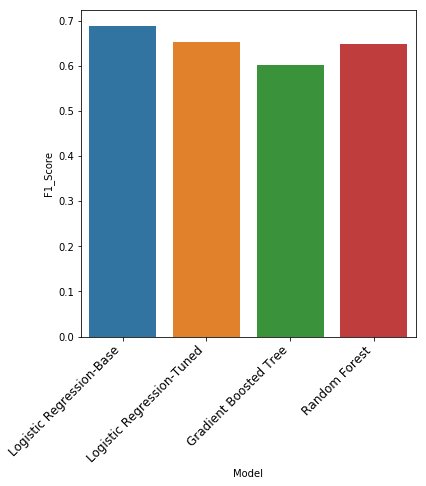

In [44]:
# Create a df for visualisation
comparison_df= pd.DataFrame(all_scores,columns=['Model', 'F1_Score'])
plt.figure(figsize=(6,6))
chart = sns.barplot(x='Model',y='F1_Score',data=comparison_df)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'
)
chart.set_yticks(np.arange(0,0.8,0.1))
plt.show()


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.